Train Mean Squared Error: 0.0026846825556297977
Train R-squared: 0.9965555588017265
Test Mean Squared Error: 0.019370748471649046
Test R-squared: 0.9760614713845606


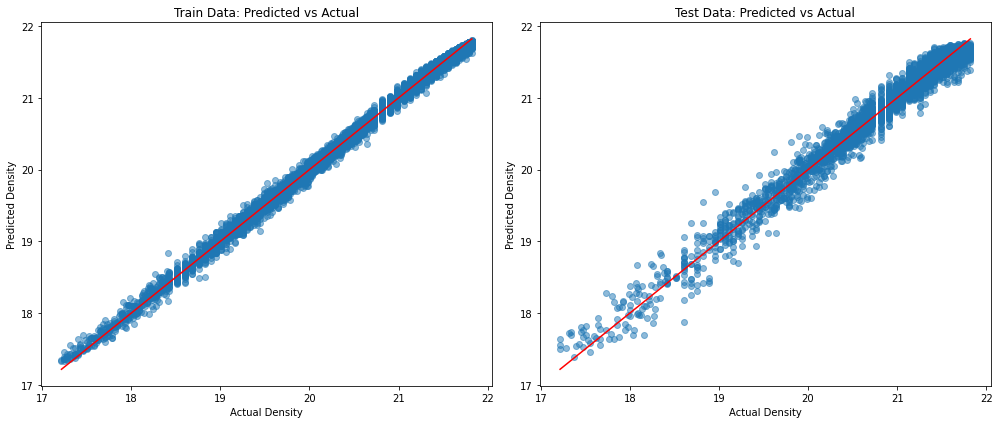

Mean Squared Error: 8463.980077598564
R-squared: 0.3933419440388257


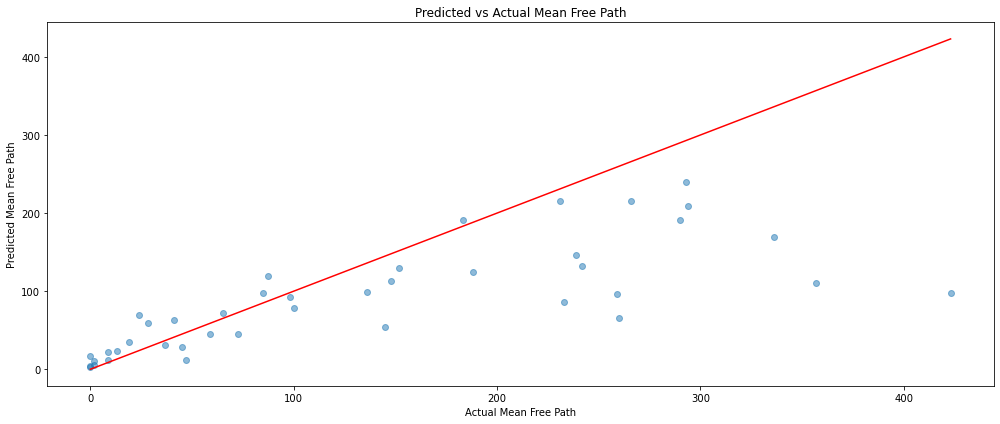

In [1]:
"""
2D Crosshatch Simulation and Machine Learning Analysis
------------------------------------------------------
This script includes functions for generating dislocation-induced surface morphology, 
analyzing the surface characteristics, and applying machine learning models 
to predict dislocation densities and electron mean free paths.

Author: Amara Keita
Date: August 2024
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Parallel, delayed
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns

def generate_dislocations(params):
    """
    Generate dislocations based on material parameters.

    Parameters:
    params (dict): Dictionary of material and simulation parameters.

    Returns:
    tuple: Meshgrid arrays X, Y and the smoothed height profile.
    """
    G = params['G']
    nu = params['nu']
    epsilon = params['epsilon_m']
    b = params['b']
    h = params['h_factor'] * b
    Lx, Ly = params['Lx'], params['Ly']
    num_points = params['num_points']
    dislocation_density_cm2 = params['dislocation_density_cm2']

    x = np.linspace(0, Lx, num_points)
    y = np.linspace(0, Ly, num_points)
    X, Y = np.meshgrid(x, y)
    height = np.zeros_like(X)

    def dislocation_line_displacement(x, y, x0, y0, h, b, G, nu, epsilon):
        r2 = (x - x0)**2 + (y - y0)**2 + h**2
        ux = b / np.pi * ((h**2 - (x - x0) * h) / r2 - np.arctan2((x - x0), h))
        uy = b / np.pi * ((h**2 - (y - y0) * h) / r2 - np.arctan2((y - y0), h))
        return np.sqrt(ux**2 + uy**2)

    def introduce_dislocation_lines(height, line_positions):
        for (x0, y0) in line_positions:
            displacement = dislocation_line_displacement(X, Y, x0, y0, h, b, G, nu, epsilon)
            height += displacement
        height = gaussian_filter(height, sigma=1.5)
        return height

    area_um2 = Lx * Ly * 1e12
    num_dislocation_lines = int(dislocation_density_cm2 * area_um2 / 1e8)
    line_positions_x = np.random.uniform(0, Lx, int(np.sqrt(num_dislocation_lines * Lx / Ly)))
    line_positions_y = np.random.uniform(0, Ly, int(np.sqrt(num_dislocation_lines * Ly / Lx)))
    line_positions = list(zip(line_positions_x, line_positions_y))
    height = introduce_dislocation_lines(height, line_positions)
    height_smoothed = gaussian_filter(height, sigma=2)
    height_smoothed = height_smoothed * 1e10  # Convert to angstroms

    return X, Y, height_smoothed

def analyze_surface(X, Y, height):
    """
    Analyze the surface roughness and characteristics.

    Parameters:
    X, Y (numpy array): Meshgrid arrays of x and y coordinates.
    height (numpy array): Surface height profile.

    Returns:
    tuple: Various metrics related to surface roughness and characteristics.
    """
    def calculate_surface_roughness(height):
        Ra = np.mean(np.abs(height - np.mean(height)))
        return Ra

    def height_distribution(height):
        mean_height = np.mean(height)
        std_dev_height = np.std(height)
        return mean_height, std_dev_height

    def analyze_profile(profile, spacing):
        peaks, _ = find_peaks(profile)
        if len(peaks) > 1:
            lambda_values = np.diff(peaks) * spacing * 1e9  # Conversion to nm
            lambda_mean = np.mean(lambda_values)
            lambda_std = np.std(lambda_values)
            epsilon = np.abs(np.mean(profile[peaks]) - np.mean(profile)) * 1e1  # Scaling factor for epsilon
            epsilon_std = np.std(np.abs(profile[peaks] - np.mean(profile))) * 1e1
        else:
            lambda_mean = np.nan
            lambda_std = np.nan
            epsilon = np.nan
            epsilon_std = np.nan

        return lambda_mean, lambda_std, epsilon, epsilon_std

    # Analyze the X profile
    height_profile_x = height[int(height.shape[0] / 2), :]
    spacing_x = X[0, 1] - X[0, 0]
    lambda_mean_x, lambda_std_x, epsilon_x, epsilon_std_x = analyze_profile(height_profile_x, spacing_x)

    # Analyze the Y profile
    height_profile_y = height[:, int(height.shape[1] / 2)]
    spacing_y = Y[1, 0] - Y[0, 0]
    lambda_mean_y, lambda_std_y, epsilon_y, epsilon_std_y = analyze_profile(height_profile_y, spacing_y)

    Ra = calculate_surface_roughness(height)
    mean_height, std_dev_height = height_distribution(height)

    return lambda_mean_x, lambda_std_x, lambda_mean_y, lambda_std_y, epsilon_x, epsilon_std_x, epsilon_y, epsilon_std_y, Ra, mean_height, std_dev_height

def process_density(density, params, idx):
    """
    Process and analyze surface morphology for a given dislocation density.

    Parameters:
    density (float): Dislocation density.
    params (dict): Dictionary of material and simulation parameters.
    idx (int): Index of the current density being processed.

    Returns:
    list: Metrics related to the analyzed surface morphology.
    """
    params['dislocation_density_cm2'] = density
    X, Y, height_smoothed = generate_dislocations(params)
    metrics = analyze_surface(X, Y, height_smoothed)
    
    return [f"InGaAs_{density:.1e}"] + list(metrics)

def main_simulation():
    """
    Main function to run the dislocation density simulations.

    Generates the dataset by simulating surface morphology for a range of dislocation densities.
    """
    params = {
        'G': 5.7e10,          # Shear modulus (Pa)
        'nu': 0.35,           # Poisson's ratio
        'epsilon_m': 0.018,   # Lattice mismatch strain
        'b': 6.1e-10,         # Burgers vector (m)
        'h_factor': 100,      # Depth factor relative to b
        'Lx': 2e-5,           # Simulation domain size (20 micrometers)
        'Ly': 2e-5,           # Simulation domain size (20 micrometers)
        'num_points': 1000,   # Number of grid points
        'dislocation_density_cm2': 3e8  # Initial dislocation density per cm^2
    }
    densities = np.linspace(3e7, 3e9, num=17900)

    results = Parallel(n_jobs=-1)(delayed(process_density)(density, params, idx) for idx, density in tqdm(enumerate(densities), total=len(densities)))

    with open('surface_analysis_InGaAs_17900.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Image Name', 'lambda_x', 'lambda_x_std', 'lambda_y', 'lambda_y_std', 
                         'epsilon_x', 'epsilon_x_std', 'epsilon_y', 'epsilon_y_std', 
                         'Ra', 'mean_height', 'std_dev_height'])
        writer.writerows(results)

    print("Analysis complete and results saved to 'surface_analysis_InGaAs_17900.csv'.")

def train_model_on_density():
    """
    Train a Random Forest model to predict dislocation density from AFM features.

    Evaluates the model performance and visualizes the results.
    """
    file_path = 'surface_analysis_InGaAs_17900.csv'
    data = pd.read_csv(file_path)

    data['density'] = data['Image Name'].apply(lambda x: float(x.split('_')[1].replace('e+', 'e')))
    features = data[['lambda_x', 'lambda_x_std', 'lambda_y', 'lambda_y_std', 'epsilon_x', 'epsilon_x_std', 'epsilon_y', 'epsilon_y_std']]
    target = data['density']

    features = np.log(features + 1)
    target = np.log(target + 1)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(random_state=42)
    best_params = {'n_estimators': 938, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
    model.set_params(**best_params)

    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("Train Mean Squared Error:", mse_train)
    print("Train R-squared:", r2_train)
    print("Test Mean Squared Error:", mse_test)
    print("Test R-squared:", r2_test)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')
    plt.title('Train Data: Predicted vs Actual')
    plt.xlabel('Actual Density')
    plt.ylabel('Predicted Density')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.title('Test Data: Predicted vs Actual')
    plt.xlabel('Actual Density')
    plt.ylabel('Predicted Density')

    plt.tight_layout()
    plt.show()

def predict_mean_free_path():
    """
    Train a Random Forest model to predict the mean free path based on AFM features.

    Evaluates the model performance and visualizes the results.
    """
    dataset_path = 'new_data_with_predictions.csv'
    data = pd.read_csv(dataset_path)

    features = data[['lambda_x', 'lambda_x_std', 'lambda_y', 'lambda_y_std', 'epsilon_x', 'epsilon_x_std', 'epsilon_y', 'epsilon_y_std', 'predicted_density']]
    target = data['mean_free_path']

    log_features = np.log(features + 1)
    log_target = np.log(target + 1)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(log_features)

    best_params = {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto'}
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(features_scaled, log_target)

    predicted_log_target = model.predict(features_scaled)
    predicted_target = np.exp(predicted_log_target) - 1

    mse = mean_squared_error(target, predicted_target)
    r2 = r2_score(target, predicted_target)

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    plt.figure(figsize=(14, 6))
    plt.scatter(target, predicted_target, alpha=0.5)
    plt.plot([min(target), max(target)], [min(target), max(target)], color='red')
    plt.title('Predicted vs Actual Mean Free Path')
    plt.xlabel('Actual Mean Free Path')
    plt.ylabel('Predicted Mean Free Path')
    plt.tight_layout()
    plt.savefig('Predicted_vs_Actual_MFP.pdf', format='pdf')
    plt.show()

if __name__ == "__main__":
    #main_simulation()
    train_model_on_density()
    predict_mean_free_path()


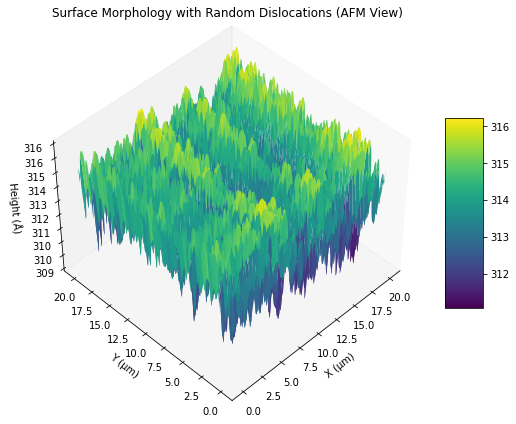

In [6]:
def plot_afm_surface(X, Y, height, title="Surface Morphology with Random Dislocations (AFM View)"):
    """
    Plot the 3D AFM surface morphology.
    
    Parameters:
    X, Y (numpy array): Meshgrid arrays of x and y coordinates.
    height (numpy array): Surface height profile.
    title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X * 1e6, Y * 1e6, height, cmap='viridis', edgecolor='none')

    ax.view_init(elev=45, azim=-135)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_zlabel('Height (Å)')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda z, _: '{:.0f}'.format(z)))
    ax.grid(False)
    plt.savefig('3D_Simulation_Surface_Morphology_with_Random_Dislocations(AFM View).png', dpi=300)
    plt.show()
params_InGaAs = {
        'G': 5.7e10,          # Shear modulus (Pa)
        'nu': 0.35,           # Poisson's ratio
        'epsilon_m': 0.018,   # Lattice mismatch strain
        'b': 6.1e-10,         # Burgers vector (m)
        'h_factor': 100,      # Depth factor relative to b
        'Lx': 2e-5,           # Simulation domain size (20 micrometers)
        'Ly': 2e-5,           # Simulation domain size (20 micrometers)
        'num_points': 1000,   # Number of grid points
        'dislocation_density_cm2': 1.4e9  # Initial dislocation density per cm^2
    }
X, Y, height_smoothed = generate_dislocations(params = params_InGaAs)
plot_afm_surface(X, Y, height_smoothed, title="Surface Morphology with Random Dislocations (AFM View)")

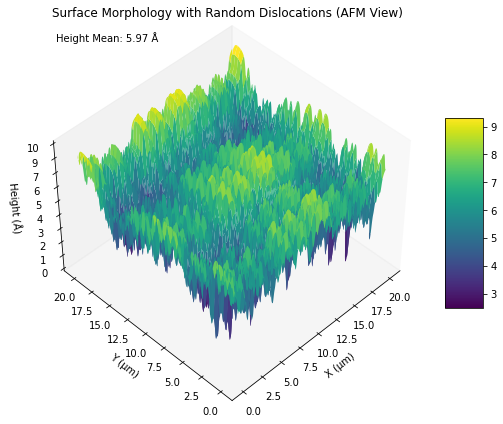

In [5]:
def plot_afm_surface(X, Y, height, title="Surface Morphology with Random Dislocations (AFM View)", file_name="plot.pdf"):
    # Normalize the height values to start from 0
    height_normalized = height - np.min(height)
    height_mean = np.mean(height_normalized)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X * 1e6, Y * 1e6, height_normalized, cmap='viridis', edgecolor='none')

    ax.view_init(elev=45, azim=-135)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_zlabel('Height (Å)')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Set z-axis limits to start from 0 to max - min
    ax.set_zlim(0, np.max(height_normalized))
    
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda z, _: '{:.0f}'.format(z)))
    ax.grid(False)
    
    # Add annotation for height mean
    ax.text2D(0.05, 0.95, f'Height Mean: {height_mean:.2f} Å', transform=ax.transAxes)
    
    # Save the plot as a PDF file
    #plt.savefig(file_name, format='pdf')
    plt.savefig(f'{title}.png', dpi=300)
    plt.show()

plot_afm_surface(X, Y, height_smoothed, title="Surface Morphology with Random Dislocations (AFM View)")

In [21]:
params_InGaAs = {
        'G': 5.7e10,          # Shear modulus (Pa)
        'nu': 0.35,           # Poisson's ratio
        'epsilon_m': 0.018,   # Lattice mismatch strain
        'b': 6.1e-10,         # Burgers vector (m)
        'h_factor': 100,      # Depth factor relative to b
        'Lx': 2e-5,           # Simulation domain size (20 micrometers)
        'Ly': 2e-5,           # Simulation domain size (20 micrometers)
        'num_points': 1000,   # Number of grid points
        'dislocation_density_cm2': 1.3e9  # Initial dislocation density per cm^2
    }
X, Y, height_smoothed = generate_dislocations(params = params_InGaAs)

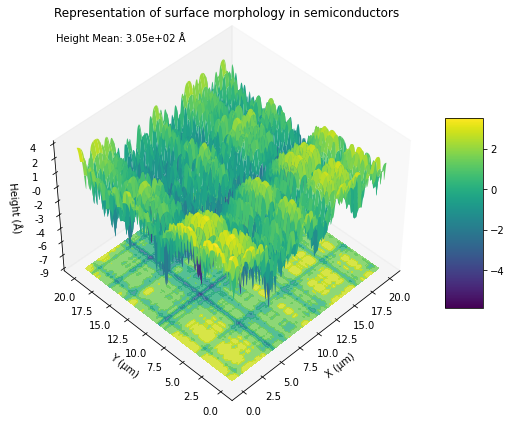

In [28]:
def plot_afm_surface(X, Y, height, title="Representation of surface morphology in semiconductors", file_name="plot.pdf"):
    # Calculate the mean and centered height
    height_mean = np.mean(height)
    height_centered = height - height_mean
    
    # Create the plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main surface plot
    surf = ax.plot_surface(X * 1e6, Y * 1e6, height_centered, cmap='viridis', edgecolor='none')

    # Filled contour underneath
    ax.contourf(X * 1e6, Y * 1e6, height_centered, zdir='z', offset=np.min(height_centered), cmap='viridis', alpha=0.8)
    
    ax.view_init(elev=45, azim=-135)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_zlabel('Height (Å)')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Set z-axis limits from min centered height to max centered height
    ax.set_zlim(np.min(height_centered), np.max(height_centered))
    
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda z, _: '{:.0f}'.format(z)))
    ax.grid(False)
    
    # Add annotation for height mean (which will now be 0)
    ax.text2D(0.05, 0.95, f'Height Mean: {height_mean:.2e} Å', transform=ax.transAxes)
    
    # Save the plot as a PNG file
    plt.savefig('surface_morphology_diagram.png', dpi=300)
    plt.show()

plot_afm_surface(X, Y, height_smoothed)
